<a href="https://colab.research.google.com/github/vinupillai/data-science-notebooks/blob/master/Twitter_US_Airline_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter US Airline Sentiment

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

The dataset has the following columns:
* tweet_id
* airline_sentiment
* airline_sentiment_confidence
* negativereason
* negativereason_confidence
* airline
* airline_sentiment_gold
* name
* negativereason_gold
* retweet_count
* text
* tweet_coord
* tweet_created
* tweet_location
* user_timezone

## Mount the drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import the libraries

In [2]:
import re
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import sys
from tqdm.notebook import tqdm

try:
    import spacy
except:
    !{sys.executable} -m pip install spacy
    !{sys.executable} -m spacy download en_core_web_sm
    import spacy

try:
    import nltk
    nltk.download('wordnet')
    nltk.download('averaged_perceptron_tagger')
    nltk.download('punkt')
    nltk.download('stopwords')
    from nltk import pos_tag
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords, wordnet
except:
    !{sys.executable} -m pip install nltk
    nltk.download('wordnet')
    nltk.download('averaged_perceptron_tagger')
    nltk.download('punkt')
    nltk.download('stopwords')
    import nltk
    from nltk import pos_tag
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer

try:
    from porter2stemmer import Porter2Stemmer
except:
    !{sys.executable} -m pip install porter2stemmer
    from porter2stemmer import Porter2Stemmer

try:
    from textblob import TextBlob
except:
    !{sys.executable} -m pip install textblob
    from textblob import TextBlob

try:
    import contractions
except:
    !{sys.executable} -m pip install contractions
    import contractions

try:
    from catboost import CatBoostClassifier, Pool, CatBoost
except:
    !{sys.executable} -m pip install catboost
    from catboost import CatBoostClassifier, Pool, CatBoost
    
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from bs4 import BeautifulSoup

import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Define Constants
Following constants are used within the data processing steps. 

- **Stemmer**
  - P1 = Porter
  - P2 = Porter2
  - L = Lancaster
- **lemmatizer**
  - W = Wordnet
  - S = Spacy
  - T = TextBlob
- **Vectorizer**
  - C = CountVectorizer
  - T = TfidfVectorizer


In [0]:
wordnet_tag_dict = {'J': wordnet.ADJ, 'N': wordnet.NOUN, 'V': wordnet.VERB, 'R': wordnet.ADV}

# P1 -> Porter, P2 -> Porter2, L -> Lancaster
stemmer = 'P2'

# W -> Wordnet, S -> Spacy, T -> TextBlob
lemmatizer = 'W'

# C -> CountVectorizer, T -> TfidfVectorizer
vectorizer = 'T'

#Maximum features for vectorization
max_features = 5000

## Define Common Functions

In [0]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('YlOrRd')

    #plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\n\naccuracy={:0.4f}; miss-classification={:0.4f}'.format(accuracy, misclass))

def print_model_performance(model, X_test_actuals, y_test_actuals):
    print('Accuracy = {:0.4f}%.'.format(model.score(X_test_actuals, y_test_actuals) * 100))
    
def print_model_score(model_name, y_actual, y_predictions):
    print('Model Score Summary for ' + model_name)
    print('------------------------------------------------------')
    print(classification_report(y_actual, y_predictions))
    
def print_class_weights(classes, y_variable):
    # computing the class weight ratio
    weighting = compute_class_weight('balanced', classes, y_variable)
    print(weighting)

def drop_columns(df):
    return df[['airline_sentiment', 'text']]

def get_stemmer():
    if stemmer == 'P1':
        return PorterStemmer()
    elif stemmer == 'P2':
        return Porter2Stemmer()
    elif stemmer == 'L':
        return LancasterStemmer()
    
def get_vectorizer(vectorizer='C', ngram_range=(1,1)):
    if vectorizer == 'C':
        return CountVectorizer(analyzer='word', ngram_range=ngram_range, max_features = max_features)
    elif vectorizer == 'T':
        return TfidfVectorizer(analyzer='word', ngram_range=ngram_range, max_features = max_features)

def get_wordnet_pos(word):
    return wordnet_tag_dict.get(nltk.pos_tag([word])[0][1][0].upper(), wordnet.NOUN)
  
def get_lemmatization(sentence=None):
    if lemmatizer == 'W':
        return WordNetLemmatizer()
    elif lemmatizer == 'S':
        return spacy.load('en_core_web_sm')
    elif lemmatizer == 'T':
        return TextBlob(sentence)

def lower_text(df):
    df['text'] = df['text'].str.lower()
    return df

def extract_tokens(df):
    def separate_tokens(text):
        text = contractions.fix(text)
        tokens = word_tokenize(text)
        #take only words and ignore punctuation, html urls, numbers & special characters
        return [token for token in tokens if token.isalpha()]
    tqdm.pandas(desc='Extracting Tokens')
    df['text'] = df['text'].progress_apply(separate_tokens)
    return df

def stop_words(df):
    stop_words = set(stopwords.words('english'))
    def remove_stop_word(word_tokens):
        return [word for word in word_tokens if not word in stop_words]
    tqdm.pandas(desc='Removing Stop words')
    df['text'] = df['text'].progress_apply(remove_stop_word)
    return df

def stem_it(df):
    stemm = get_stemmer()
    def stem_word(word_tokens):
        return [stemm.stem(word) for word in word_tokens]
    tqdm.pandas(desc='Replacing with stems')
    df['text'] = df['text'].progress_apply(stem_word)
    return df

def lemmatize_it(df):
    def lemmatize_words(word_tokens):
        if lemmatizer == 'W':
            lemmatization = get_lemmatization()
            return [lemmatization.lemmatize(word, get_wordnet_pos(word)) for word in word_tokens]
        elif lemmatizer == 'S':
            lemmatization = get_lemmatization()
            return [word.lemma_ for word in lemmatization(' '.join([word for word in word_tokens]))]
        elif lemmatizer == 'TB':
            lemmatization = get_lemmatization(' '.join([word for word in word_tokens]))
            words_and_pos = [(word, get_wordnet_pos(pos[0])) for word, pos in lemmatization.tags]    
            return [word.lemmatize(tag) for word, tag in words_and_pos]
    tqdm.pandas(desc='Lemmatizing words')
    df['text'] = df['text'].progress_apply(lemmatize_words)
    return df

def vectorize_it_with_count(df):
    vectorizr = get_vectorizer()
    values = vectorizr.fit_transform(df['text'])
    features = vectorizr.get_feature_names()
    df = pd.concat([df, pd.DataFrame(data=values.todense(), columns=features)], axis=1, sort=False)
    return df

def vectorize_it_with_tfidf(df):
    vectorizr = get_vectorizer('T')
    values = vectorizr.fit_transform(df['text'])
    features = vectorizr.get_feature_names()
    df = pd.concat([df, pd.DataFrame(data=values.todense(), columns=features)], axis=1, sort=False)
    return df

def remove_html_tags(df):
    def strip_html(text):
        return BeautifulSoup(text, 'html.parser').get_text()
    tqdm.pandas(desc='Stripping HTML tags')
    df['text'] = df['text'].progress_apply(strip_html)
    return df

def make_sentence(df):
    def form_sentence(word_tokens):
        return ' '.join([word for word in word_tokens])
    tqdm.pandas(desc='Converting to Sentence')
    df['text'] = df['text'].progress_apply(form_sentence)
    return df
  
def extract_X_y(df):
    X = df.iloc[:,2:]
    y = df[['airline_sentiment']]
    labelEncoder = LabelEncoder()
    y_encoded = labelEncoder.fit_transform(y['airline_sentiment'])
    return X, y, y_encoded

def fit_random_forest(train_x, train_y, test_x, test_y):
    rf_classifier = RandomForestClassifier(n_estimators=150, class_weight=class_weights, criterion = 'entropy', max_depth = 10, min_samples_leaf=5, random_state=1)
    rf_classifier.fit(train_x, train_y)
    rf_predictions = rf_classifier.predict(test_x)
    print_model_performance(rf_classifier, test_x, test_y)
    print_model_score('RandomForest Classifier', test_y, rf_predictions)
    plot_confusion_matrix(cm           = metrics.confusion_matrix(test_y, rf_predictions), 
                          normalize    = False,
                          target_names = ['negative', 'neutral', 'positive'],
                          title        = "Confusion Matrix")
    return rf_classifier, accuracy_score(test_y, rf_predictions)

def fit_gradient_boosting(train_x, train_y, test_x, test_y):
    gsv_gb_param_grid = {
        "loss": ['deviance'],
        "learning_rate": [0.2],
        "max_features":['sqrt'],
        "subsample":[1.0],
        "criterion": ["friedman_mse"],
        "n_estimators":[150],
        "min_samples_leaf":[5],
        "max_depth":[10],
        "min_impurity_decrease":[1e-7]
    }
    # Instantiate the grid search model
    grid_search_gb = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid = gsv_gb_param_grid, cv = 10, n_jobs = -1, verbose = 1)
    # Fit the grid search to the data
    grid_search_gb.fit(train_x, train_y)
    print('Best Parameters are: ')
    print(grid_search_gb.best_params_)
    best_grid_gb = grid_search_gb.best_estimator_
    gsv_gb_predictions = best_grid_gb.predict(test_x)
    print_model_performance(best_grid_gb, test_x, test_y)
    print_model_score('Gradient Boosting with Grid Search Classifier', test_y, gsv_gb_predictions)
    plot_confusion_matrix(cm           = metrics.confusion_matrix(test_y, gsv_gb_predictions), 
                          normalize    = False,
                          target_names = ['negative', 'neutral', 'positive'],
                          title        = "Confusion Matrix")
    return best_grid_gb, accuracy_score(test_y, gsv_gb_predictions)

def fit_lgbm(train_x, train_y, eval_x, eval_y, test_x, test_y):
    lgb_train = lgb.Dataset(train_x, label=train_y)
    lgb_valid = lgb.Dataset(eval_x, label=eval_y)

    lgb_params = {
        "objective"         : "multiclass",
        "metrics"           : "multi_logloss",
        "num_class"         : 3,
        "max_bin"           : 200,
        "num_leaves"        : 60,
        "max_depth"         : 7,
        "learning_rate"     : 0.01,
        "bagging_fraction"  : 0.9,
        "feature_fraction"  : 0.9,
        "bagging_freq"      : 5,
        "bagging_seed"      : 1
    }
    lgb_classifier = lgb.train(lgb_params, lgb_train, 2000, valid_sets=[lgb_train, lgb_valid], verbose_eval=500)
    lgb_predictions = [np.argmax(line) for line in lgb_classifier.predict(test_x)]
    print_model_score('LGB Classifier', test_y, lgb_predictions)
    plot_confusion_matrix(cm           = metrics.confusion_matrix(test_y, lgb_predictions), 
                          normalize    = False,
                          target_names = ['negative', 'neutral', 'positive'],
                          title        = "Confusion Matrix")
    return lgb_classifier, accuracy_score(test_y, lgb_predictions)

def fit_catboost(train_x, train_y, eval_x, eval_y, test_x, test_y):
    cat_train = Pool(data=train_x, label=train_y, cat_features=None)
    cat_eval = Pool(data=eval_x, label=eval_y, cat_features=None)
    cat_test = Pool(data=test_x, label=test_y, cat_features=None)
    cat_model = CatBoost({'loss_function' : 'MultiClass', 
                          'custom_metric' : 'Accuracy', 
                          'eval_metric'   : 'Accuracy', 
                          'learning_rate' : 1, 
                          'verbose'       : 250, 
                          'random_seed'   : 1, 'l2_leaf_reg': 5.0, 'random_strength': 3, 'grow_policy': 'Depthwise',
                          'depth'         : 8})
    cat_model.fit(cat_train, eval_set=[cat_train, cat_eval])
    cat_predictions = np.asarray([np.argmax(line) for line in cat_model.predict(cat_test)])
    print_model_score('CatBoost Model', test_y, cat_predictions)
    plot_confusion_matrix(cm           = metrics.confusion_matrix(test_y, cat_predictions), 
                          normalize    = False,
                          target_names = ['negative', 'neutral', 'positive'],
                          title        = "Confusion Matrix")
    return cat_model, accuracy_score(test_y, cat_predictions)

def fit_xgb(train_x, train_y, test_x, test_y):
    xgb_train = xgb.DMatrix(train_x, label=train_y)
    xgb_test = xgb.DMatrix(test_x, label=test_y)

    param = {
        'eta': 0.3, 
        'max_depth': 3,  
        'objective': 'multi:softprob',  
        'num_class': 3
    }
    steps = 20  # The number of training iterations
    xgb_classifier = xgb.train(param, xgb_train, steps)
    xgb_predictions = np.asarray([np.argmax(line) for line in xgb_classifier.predict(xgb_test)])
    print_model_score('XGB Classifier', test_y, xgb_predictions)
    plot_confusion_matrix(cm           = metrics.confusion_matrix(test_y, xgb_predictions), 
                          normalize    = False,
                          target_names = ['negative', 'neutral', 'positive'],
                          title        = "Confusion Matrix")
    return xgb_classifier, accuracy_score(test_y, xgb_predictions)

## Load Dataset

In [5]:
tweets = pd.read_csv('/content/drive/My Drive/Learning/ML/Tweets.csv')
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## Data Description

In [6]:
tweets.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [7]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

## Data Preprocessing

### Shape of Dataset

In [8]:
tweets.shape

(14640, 15)

### Preprocessing
Following tasks are done on the dataframe using the pipe feature by chaining functions
* Drop all other columns except “text” and “airline_sentiment”
* Html tag removal - Done using 'remove_html_tags' function using BeautifulSoup library
* Tokenization - Done using the 'extract_tokens' function which removes, special characters, numbers, punctuations and tokenizes it.
* Remove the numbers - Done using the 'extract_tokens' function which removes, special characters, numbers, punctuations and tokenizes it.
* Removal of Special Characters and Punctuations - Done using the 'extract_tokens' function which removes, special characters, numbers, punctuations and tokenizes it.
* Conversion to lowercase - Done using the 'lower_text' function
* Lemmatize - Controlled by 'lemmatizer' variable. Use 'W', 'S' or 'T' as per documentation above
* stemming - Controlled by 'stemmer' variable. Use 'P1', 'P2' or 'L' as per documentation above
* Join the words in the list to convert back to text string in the dataframe

### Stemmer with Count Vectorizer

In [9]:
processed_stem_tweets_count_vec = tweets.copy().pipe(drop_columns).pipe(
    remove_html_tags).pipe(lower_text).pipe(extract_tokens).pipe(
        stop_words).pipe(stem_it).pipe(make_sentence).pipe(vectorize_it_with_count)
processed_stem_tweets_count_vec.head()

,airline_sentiment,text,aa,aadv,aadvantag,aafail,aarp,abandon,abc,abcnetwork,abil,abl,aboard,abq,abroad,absolut,absorb,absurd,abt,abus,abysm,ac,acc,accept,access,accid,accident,accommod,accompani,accomplish,accord,account,accru,acct,accur,accus,achiev,acknowledg,acquir,acquisit,...,wut,wx,xna,xoxo,xt,xx,ya,yard,yay,yea,yeah,year,yell,yep,yes,yest,yesterday,yet,yike,yo,york,youareonyourown,young,yousuck,youth,yow,yr,yrs,yuck,yuma,yummi,yup,yvonn,yvr,yyz,zero,zkatch,zone,zoom,zurich
0,neutral,virginamerica dhepburn said,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,positive,virginamerica plus ad commerci experi tacki,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,neutral,virginamerica today must mean nee take anoth trip,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,negative,virginamerica realli aggress blast obnoxi ente...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,negative,virginamerica realli big bad thing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Stemmer with TfidfVectorizer

In [10]:
processed_stem_tweets_tfidf_vec = tweets.copy().pipe(drop_columns).pipe(
    remove_html_tags).pipe(lower_text).pipe(extract_tokens).pipe(
        stop_words).pipe(stem_it).pipe(make_sentence).pipe(vectorize_it_with_tfidf)
processed_stem_tweets_tfidf_vec.head()

,airline_sentiment,text,aa,aadv,aadvantag,aafail,aarp,abandon,abc,abcnetwork,abil,abl,aboard,abq,abroad,absolut,absorb,absurd,abt,abus,abysm,ac,acc,accept,access,accid,accident,accommod,accompani,accomplish,accord,account,accru,acct,accur,accus,achiev,acknowledg,acquir,acquisit,...,wut,wx,xna,xoxo,xt,xx,ya,yard,yay,yea,yeah,year,yell,yep,yes,yest,yesterday,yet,yike,yo,york,youareonyourown,young,yousuck,youth,yow,yr,yrs,yuck,yuma,yummi,yup,yvonn,yvr,yyz,zero,zkatch,zone,zoom,zurich
0,neutral,virginamerica dhepburn said,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,positive,virginamerica plus ad commerci experi tacki,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,neutral,virginamerica today must mean nee take anoth trip,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,negative,virginamerica realli aggress blast obnoxi ente...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,negative,virginamerica realli big bad thing,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Lemmatizer with CountVectorizer

In [11]:
processed_lemma_tweets_count_vec = tweets.copy().pipe(drop_columns).pipe(
    remove_html_tags).pipe(lower_text).pipe(extract_tokens).pipe(
        stop_words).pipe(lemmatize_it).pipe(make_sentence).pipe(vectorize_it_with_tfidf)
processed_lemma_tweets_count_vec.head()

,airline_sentiment,text,aa,aadv,aadvantage,aafail,aarp,abandon,abc,abcnetwork,ability,able,aboard,abq,abroad,absolute,absolutely,absurd,abt,abuse,abysmal,ac,accept,acceptable,accepted,access,accident,accidentally,accommodate,accommodation,accomplish,accord,accordingly,account,accountability,accrue,acct,accts,accurate,accuse,...,wut,wx,xna,xoxo,xt,xx,ya,yard,yay,yea,yeah,year,yearly,yell,yep,yes,yest,yesterday,yet,yikes,yo,york,youareonyourown,young,yousuck,youth,yow,yr,yuck,yuma,yummy,yup,yvonne,yvr,yyz,zero,zkatcher,zone,zoom,zurich
0,neutral,virginamerica dhepburn say,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,positive,virginamerica plus add commercial experience t...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,neutral,virginamerica today must mean need take anothe...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,negative,virginamerica really aggressive blast obnoxiou...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,negative,virginamerica really big bad thing,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Lemmatizer with TfidfVectorizer

In [12]:
processed_lemma_tweets_tfidf_vec = tweets.copy().pipe(drop_columns).pipe(
    remove_html_tags).pipe(lower_text).pipe(extract_tokens).pipe(
        stop_words).pipe(lemmatize_it).pipe(make_sentence).pipe(vectorize_it_with_tfidf)
processed_lemma_tweets_tfidf_vec.head()

,airline_sentiment,text,aa,aadv,aadvantage,aafail,aarp,abandon,abc,abcnetwork,ability,able,aboard,abq,abroad,absolute,absolutely,absurd,abt,abuse,abysmal,ac,accept,acceptable,accepted,access,accident,accidentally,accommodate,accommodation,accomplish,accord,accordingly,account,accountability,accrue,acct,accts,accurate,accuse,...,wut,wx,xna,xoxo,xt,xx,ya,yard,yay,yea,yeah,year,yearly,yell,yep,yes,yest,yesterday,yet,yikes,yo,york,youareonyourown,young,yousuck,youth,yow,yr,yuck,yuma,yummy,yup,yvonne,yvr,yyz,zero,zkatcher,zone,zoom,zurich
0,neutral,virginamerica dhepburn say,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,positive,virginamerica plus add commercial experience t...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,neutral,virginamerica today must mean need take anothe...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,negative,virginamerica really aggressive blast obnoxiou...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,negative,virginamerica really big bad thing,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model Building
### Independent & Target Variables
Extracting the independent and target variables.

The Lemmatizer and TfidfVectorization dataset is picked for processing. Similar process can be applied for all the remaining 3 datasets also.

X and y variables are separated and the target variable is also encoded for model building

In [0]:
X_lemma_tweets_tfidf, y, y_encoded = extract_X_y(processed_lemma_tweets_tfidf_vec)
X_lemma_tweets_count, y, y_encoded = extract_X_y(processed_lemma_tweets_count_vec)
X_stem_tweets_tfidf, y, y_encoded = extract_X_y(processed_stem_tweets_tfidf_vec)
X_stem_tweets_count, y, y_encoded = extract_X_y(processed_stem_tweets_count_vec)

### Defining Class weight

In [14]:
print_class_weights([0, 1, 2], y_encoded)

[0.53170625 1.57470152 2.06517139]


In [0]:
class_weights = {0:0.53170625, 1:1.57470152, 2:2.06517139}

### Classification for Count Vectorized data

Test Train Split for training and validation

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_lemma_tweets_count, y_encoded, test_size=0.1, random_state=1, stratify=y)
X_train_split, X_eval_split, y_train_split, y_eval_split = train_test_split(X_train, y_train, test_size=0.3, random_state=1, stratify=y_train)

#### Random Forest

Accuracy = 68.7158%.
Model Score Summary for RandomForest Classifier
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.72      0.79       918
           1       0.43      0.65      0.52       310
           2       0.61      0.61      0.61       236

    accuracy                           0.69      1464
   macro avg       0.64      0.66      0.64      1464
weighted avg       0.74      0.69      0.70      1464



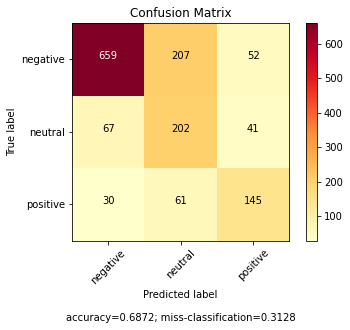

In [17]:
rf_model, rf_score = fit_random_forest(X_train, y_train, X_test, y_test)

#### Gradient Boosting

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.3min finished


Best Parameters are: 
{'criterion': 'friedman_mse', 'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 10, 'max_features': 'sqrt', 'min_impurity_decrease': 1e-07, 'min_samples_leaf': 5, 'n_estimators': 150, 'subsample': 1.0}
Accuracy = 77.7322%.
Model Score Summary for Gradient Boosting with Grid Search Classifier
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.93      0.86       918
           1       0.68      0.47      0.56       310
           2       0.75      0.59      0.66       236

    accuracy                           0.78      1464
   macro avg       0.74      0.66      0.69      1464
weighted avg       0.77      0.78      0.76      1464



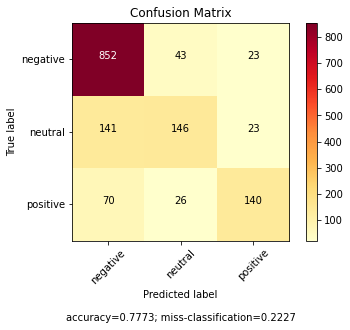

In [18]:
gb_model, gb_score = fit_gradient_boosting(X_train, y_train, X_test, y_test)

#### LGBM

[500]	training's multi_logloss: 0.595047	valid_1's multi_logloss: 0.637005
[1000]	training's multi_logloss: 0.526087	valid_1's multi_logloss: 0.596054
[1500]	training's multi_logloss: 0.483393	valid_1's multi_logloss: 0.576368
[2000]	training's multi_logloss: 0.452191	valid_1's multi_logloss: 0.565283
Model Score Summary for LGB Classifier
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.93      0.86       918
           1       0.67      0.45      0.54       310
           2       0.71      0.53      0.61       236

    accuracy                           0.76      1464
   macro avg       0.72      0.64      0.67      1464
weighted avg       0.75      0.76      0.75      1464



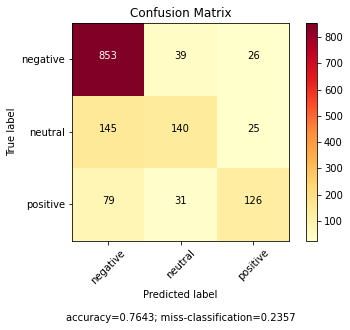

In [19]:
lgb_model, lgb_score = fit_lgbm(X_train_split, y_train_split, X_eval_split, y_eval_split, X_test, y_test)

#### CatBoost

0:	learn: 0.6474032	test: 0.6474032	test1: 0.6438148	best: 0.6438148 (0)	total: 480ms	remaining: 7m 59s
250:	learn: 0.8517836	test: 0.8517836	test1: 0.7439919	best: 0.7467746 (113)	total: 1m 44s	remaining: 5m 11s
500:	learn: 0.9040442	test: 0.9040442	test1: 0.7460157	best: 0.7467746 (113)	total: 3m 16s	remaining: 3m 16s
750:	learn: 0.9603166	test: 0.9603166	test1: 0.7485454	best: 0.7503162 (717)	total: 4m 55s	remaining: 1m 38s
999:	learn: 0.9885070	test: 0.9885070	test1: 0.7482924	best: 0.7510751 (867)	total: 6m 30s	remaining: 0us

bestTest = 0.7510751328
bestIteration = 867

Shrink model to first 868 iterations.
Model Score Summary for CatBoost Model
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       918
           1       0.61      0.42      0.50       310
           2       0.73      0.58      0.65       236

    accuracy                           0.75      1464
   macro avg 

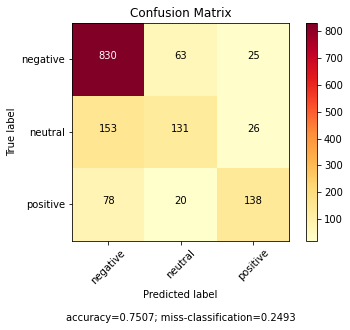

In [20]:
cat_model, cat_score = fit_catboost(X_train_split, y_train_split, X_eval_split, y_eval_split, X_test, y_test)

#### Extreme Gradient Boosting Trees

Model Score Summary for XGB Classifier
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.97      0.82       918
           1       0.75      0.15      0.25       310
           2       0.69      0.43      0.53       236

    accuracy                           0.71      1464
   macro avg       0.72      0.52      0.53      1464
weighted avg       0.72      0.71      0.65      1464



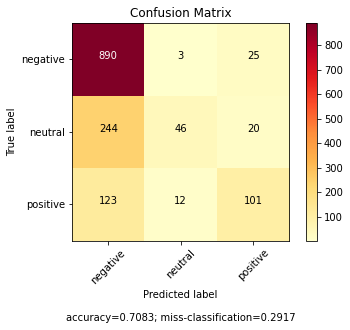

In [21]:
xgb_model, xgb_score = fit_xgb(X_train, y_train, X_test, y_test)

### Classification for Tfidf Vectorized data

Test Train Split for training and validation

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_lemma_tweets_tfidf, y_encoded, test_size=0.1, random_state=1, stratify=y)
X_train_split, X_eval_split, y_train_split, y_eval_split = train_test_split(X_train, y_train, test_size=0.3, random_state=1, stratify=y_train)

#### Random Forest

Accuracy = 68.7158%.
Model Score Summary for RandomForest Classifier
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.72      0.79       918
           1       0.43      0.65      0.52       310
           2       0.61      0.61      0.61       236

    accuracy                           0.69      1464
   macro avg       0.64      0.66      0.64      1464
weighted avg       0.74      0.69      0.70      1464



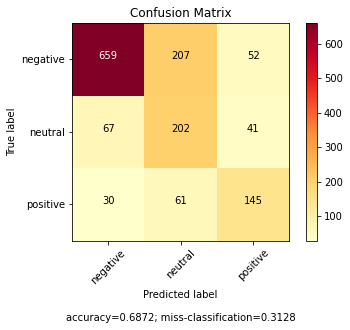

In [23]:
rf_tfidf_model, rf_tfidf_score = fit_random_forest(X_train, y_train, X_test, y_test)

#### Gradient Boosting

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.3min finished


Best Parameters are: 
{'criterion': 'friedman_mse', 'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 10, 'max_features': 'sqrt', 'min_impurity_decrease': 1e-07, 'min_samples_leaf': 5, 'n_estimators': 150, 'subsample': 1.0}
Accuracy = 78.1421%.
Model Score Summary for Gradient Boosting with Grid Search Classifier
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.94      0.86       918
           1       0.69      0.46      0.55       310
           2       0.76      0.59      0.67       236

    accuracy                           0.78      1464
   macro avg       0.75      0.66      0.70      1464
weighted avg       0.77      0.78      0.77      1464



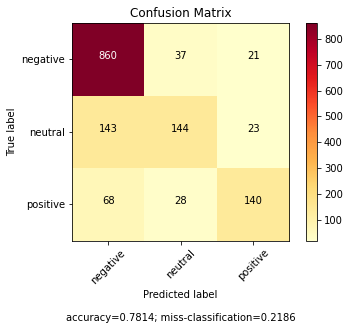

In [24]:
gb_tfidf_model, gb_tfidf_score = fit_gradient_boosting(X_train, y_train, X_test, y_test)

#### LGBM

[500]	training's multi_logloss: 0.595047	valid_1's multi_logloss: 0.637005
[1000]	training's multi_logloss: 0.526087	valid_1's multi_logloss: 0.596054
[1500]	training's multi_logloss: 0.483393	valid_1's multi_logloss: 0.576368
[2000]	training's multi_logloss: 0.452191	valid_1's multi_logloss: 0.565283
Model Score Summary for LGB Classifier
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.93      0.86       918
           1       0.67      0.45      0.54       310
           2       0.71      0.53      0.61       236

    accuracy                           0.76      1464
   macro avg       0.72      0.64      0.67      1464
weighted avg       0.75      0.76      0.75      1464



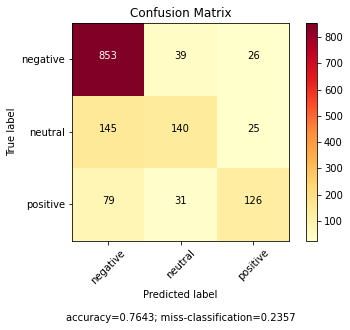

In [25]:
lgb_tfidf_model, lgb_tfidf_score = fit_lgbm(X_train_split, y_train_split, X_eval_split, y_eval_split, X_test, y_test)

#### CatBoost

0:	learn: 0.6474032	test: 0.6474032	test1: 0.6438148	best: 0.6438148 (0)	total: 424ms	remaining: 7m 3s
250:	learn: 0.8517836	test: 0.8517836	test1: 0.7439919	best: 0.7467746 (113)	total: 1m 44s	remaining: 5m 12s
500:	learn: 0.9040442	test: 0.9040442	test1: 0.7460157	best: 0.7467746 (113)	total: 3m 18s	remaining: 3m 17s
750:	learn: 0.9603166	test: 0.9603166	test1: 0.7485454	best: 0.7503162 (717)	total: 4m 57s	remaining: 1m 38s
999:	learn: 0.9885070	test: 0.9885070	test1: 0.7482924	best: 0.7510751 (867)	total: 6m 32s	remaining: 0us

bestTest = 0.7510751328
bestIteration = 867

Shrink model to first 868 iterations.
Model Score Summary for CatBoost Model
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       918
           1       0.61      0.42      0.50       310
           2       0.73      0.58      0.65       236

    accuracy                           0.75      1464
   macro avg  

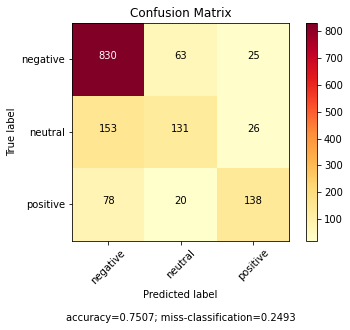

In [26]:
cat_tfidf_model, cat_tfidf_score = fit_catboost(X_train_split, y_train_split, X_eval_split, y_eval_split, X_test, y_test)

#### Extreme Gradient Boosting Trees

Model Score Summary for XGB Classifier
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.97      0.82       918
           1       0.75      0.15      0.25       310
           2       0.69      0.43      0.53       236

    accuracy                           0.71      1464
   macro avg       0.72      0.52      0.53      1464
weighted avg       0.72      0.71      0.65      1464



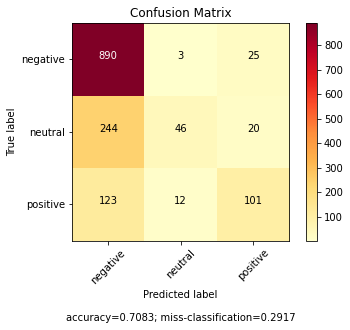

In [27]:
xgb_tfidf_model, xgb_tfidf_score = fit_xgb(X_train, y_train, X_test, y_test)

## Summary
Let us aggregate all the values for summarization

In [51]:
scores_df = pd.DataFrame({'Count Vectorizer': [rf_score, gb_score, lgb_score, cat_score, xgb_score], 
                          'TfidfVectorizer': [rf_tfidf_score, gb_tfidf_score, lgb_tfidf_score, cat_tfidf_score, xgb_tfidf_score]},
                         index =['Random Forest', 'Gradient Boosting', 'LGBM', 'CatBoost', 'XGBM'])
scores_df

,Count Vectorizer,TfidfVectorizer
Random Forest,0.687158,0.687158
Gradient Boosting,0.777322,0.781421
LGBM,0.764344,0.764344
CatBoost,0.750683,0.750683
XGBM,0.708333,0.708333


* The above scores from the models show that Gradient Boosting model with cross validation has yielded the highest accuracy for **TfidfVectorization** with an accuracy of **78%**
* The other models are fairly same and the process of vectorization or stemming has no impact on the accuracy of the model.
* The above accuracy is obtained with **5000** tokens. Reducing the parameters can improve the accuracy and perform l1 or l2 regularization to reduce overfitting. 
* Reduction of features can be achieved by either reducing the **max_features** above or by using bigrams in the vectorization phase using the ngram_range parameter, using **(1, 2)**, **(2, 2)** or **(3, 3)** etc. 